# Import the used libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
from joblib import dump

# Data Exploration

##### read Dataset

In [3]:
df=pd.read_csv('task1.csv')

In [4]:
df

,AT,V,AP,RH,PE
0,8.34,40.77,1010.84,90.01,480.48
1,23.64,58.49,1011.40,74.20,445.75
2,29.74,56.90,1007.15,41.91,438.76
3,19.07,49.69,1007.22,76.79,453.09
4,11.80,40.66,1017.13,97.20,464.43
...,...,...,...,...,...
9563,15.12,48.92,1011.80,72.93,462.59
9564,33.41,77.95,1010.30,59.72,432.90
9565,15.99,43.34,1014.20,78.66,465.96
9566,17.65,59.87,1018.58,94.65,450.93


#
#### Modify the column names to be understandable
#

In [5]:
df.rename(columns={
    'AT': 'Ambient Temperature',
    'V': 'Exhaust Vacuum',
    'AP': 'Ambient Pressure',
    'RH': 'Relative Humidity',
    'PE': 'Net Hourly Electrical Energy Output'
}, inplace=True)


#####  Display fisrt, and last 5 rows

In [6]:
df.head()

,Ambient Temperature,Exhaust Vacuum,Ambient Pressure,Relative Humidity,Net Hourly Electrical Energy Output
0,8.34,40.77,1010.84,90.01,480.48
1,23.64,58.49,1011.40,74.20,445.75
2,29.74,56.90,1007.15,41.91,438.76
3,19.07,49.69,1007.22,76.79,453.09
4,11.80,40.66,1017.13,97.20,464.43


In [7]:
df.tail()

,Ambient Temperature,Exhaust Vacuum,Ambient Pressure,Relative Humidity,Net Hourly Electrical Energy Output
9563,15.12,48.92,1011.80,72.93,462.59
9564,33.41,77.95,1010.30,59.72,432.90
9565,15.99,43.34,1014.20,78.66,465.96
9566,17.65,59.87,1018.58,94.65,450.93
9567,23.68,51.30,1011.86,71.24,451.67


##### Show 5 number summry

In [8]:
df.describe()

,Ambient Temperature,Exhaust Vacuum,Ambient Pressure,Relative Humidity,Net Hourly Electrical Energy Output
count,9568.000000,9568.000000,9568.000000,9568.000000,9568.000000
mean,19.651231,54.305804,1013.259078,73.308978,454.365009
std,7.452473,12.707893,5.938784,14.600269,17.066995
min,1.810000,25.360000,992.890000,25.560000,420.260000
25%,13.510000,41.740000,1009.100000,63.327500,439.750000
50%,20.345000,52.080000,1012.940000,74.975000,451.550000
75%,25.720000,66.540000,1017.260000,84.830000,468.430000
max,37.110000,81.560000,1033.300000,100.160000,495.760000


In [9]:
df.corr()

,Ambient Temperature,Exhaust Vacuum,Ambient Pressure,Relative Humidity,Net Hourly Electrical Energy Output
Ambient Temperature,1.000000,0.844107,-0.507549,-0.542535,-0.948128
Exhaust Vacuum,0.844107,1.000000,-0.413502,-0.312187,-0.869780
Ambient Pressure,-0.507549,-0.413502,1.000000,0.099574,0.518429
Relative Humidity,-0.542535,-0.312187,0.099574,1.000000,0.389794
Net Hourly Electrical Energy Output,-0.948128,-0.869780,0.518429,0.389794,1.000000


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9568 entries, 0 to 9567
Data columns (total 5 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Ambient Temperature                  9568 non-null   float64
 1   Exhaust Vacuum                       9568 non-null   float64
 2   Ambient Pressure                     9568 non-null   float64
 3   Relative Humidity                    9568 non-null   float64
 4   Net Hourly Electrical Energy Output  9568 non-null   float64
dtypes: float64(5)
memory usage: 373.9 KB


In [19]:
def identify_outliers(column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers

outlier_counts = {}


for column in df.columns:
    outliers = identify_outliers(column)
    outlier_count = len(outliers)
    outlier_counts[column] = outlier_count


print("Outlier counts for each column:")
for column, count in outlier_counts.items():
    print(f"{column}: {count}")


Outlier counts for each column:
Ambient Temperature: 0
Exhaust Vacuum: 0
Ambient Pressure: 88
Relative Humidity: 12
Net Hourly Electrical Energy Output: 0


In [26]:
def remove_outliers(df):
    df_no_outliers = df.copy()  # Create a copy of the DataFrame to avoid modifying the original

    for column in df.columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Remove outliers from the DataFrame
        df_no_outliers = df_no_outliers[(df_no_outliers[column] >= lower_bound) & (df_no_outliers[column] <= upper_bound)]

    return df_no_outliers

# Apply the remove_outliers function to your DataFrame
df = remove_outliers(df)


array([[<Axes: title={'center': 'Ambient Temperature'}>,
        <Axes: title={'center': 'Exhaust Vacuum'}>],
       [<Axes: title={'center': 'Ambient Pressure'}>,
        <Axes: title={'center': 'Relative Humidity'}>],
       [<Axes: title={'center': 'Net Hourly Electrical Energy Output'}>,
        <Axes: >]], dtype=object)

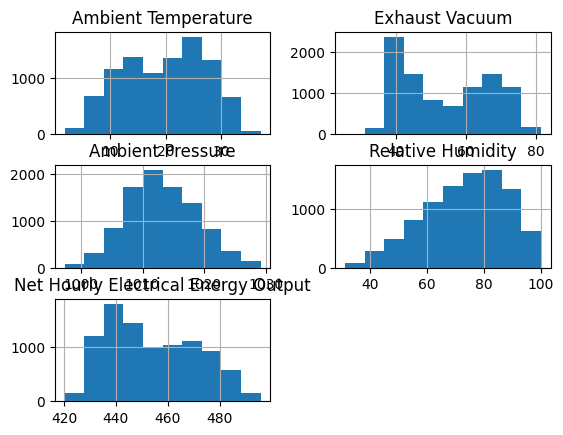

In [27]:
df.hist()

<Axes: >

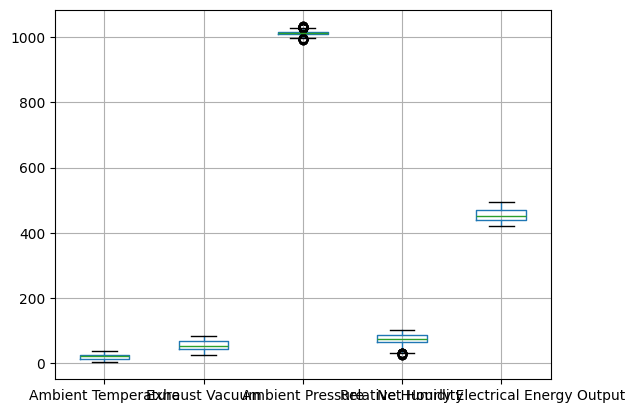

In [13]:
df.boxplot()

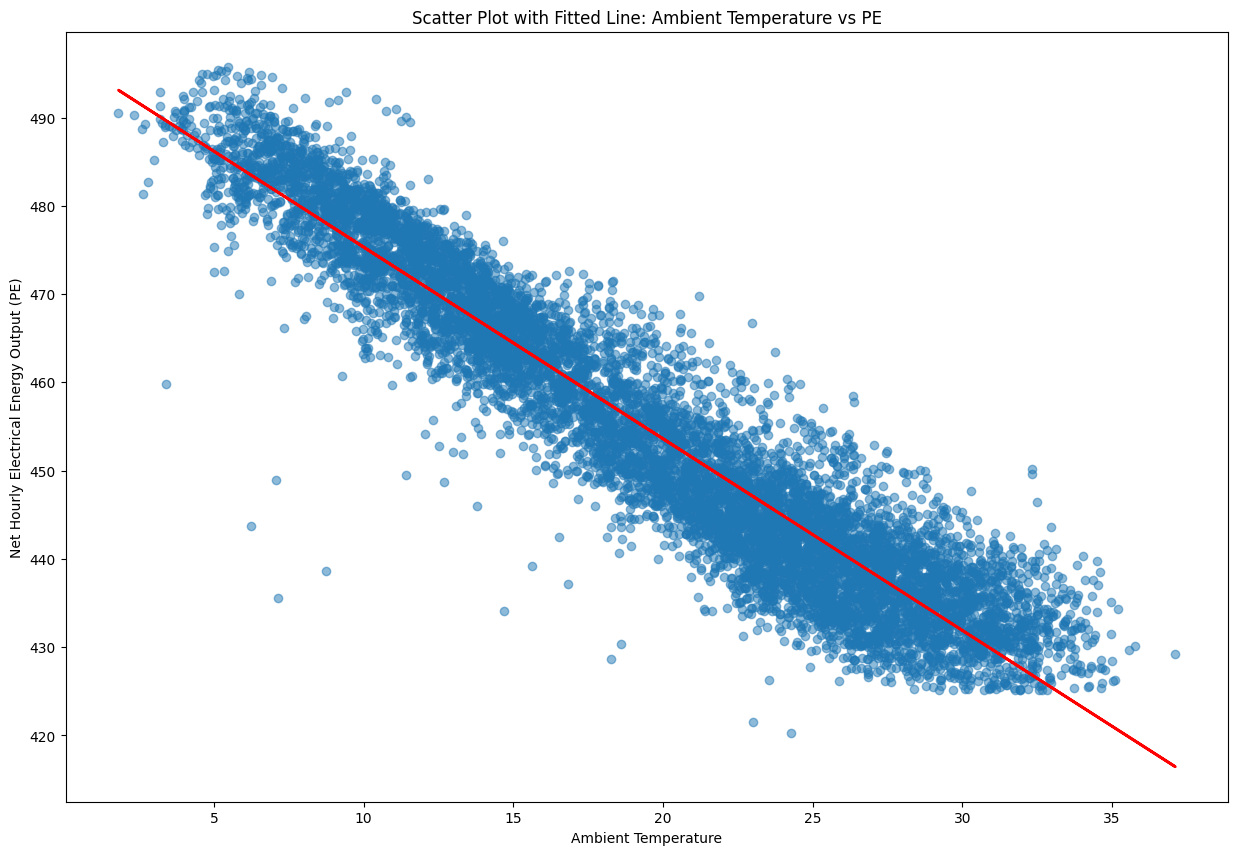

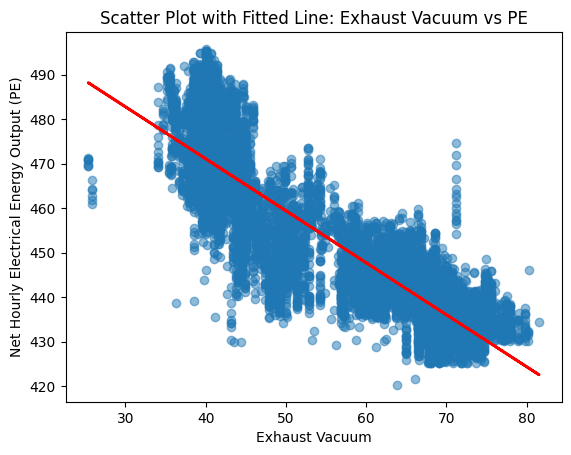

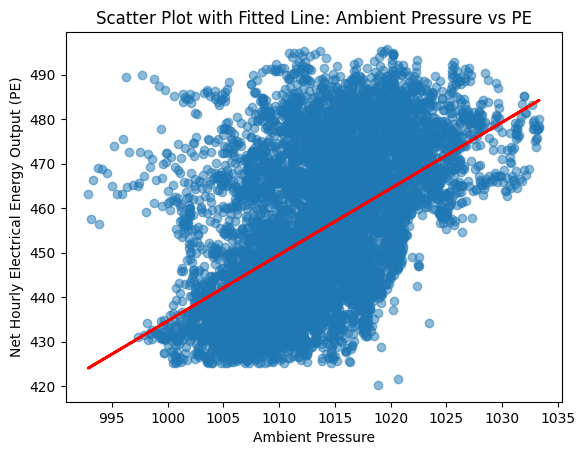

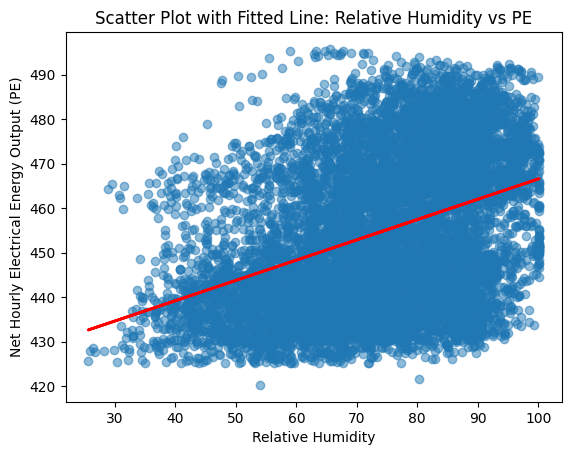

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Set the size of the figure
plt.figure(figsize=(15, 10))

# Iterate through each column (excluding the target column 'PE')
for column in df.columns[:-1]:  # Exclude the last column ('PE')
    # Scatter plot
    plt.scatter(df[column], df['Net Hourly Electrical Energy Output'], alpha=0.5)
    
    # Calculate the regression line parameters using NumPy's polyfit
    slope, intercept = np.polyfit(df[column], df['Net Hourly Electrical Energy Output'], 1)
    
    # Plot the regression line
    plt.plot(df[column], slope * df[column] + intercept, color='red', linewidth=2)
    
    # Title and labels
    plt.title(f'Scatter Plot with Fitted Line: {column} vs PE')
    plt.xlabel(column)
    plt.ylabel('Net Hourly Electrical Energy Output (PE)')
    
    # Show the plot
    plt.show()


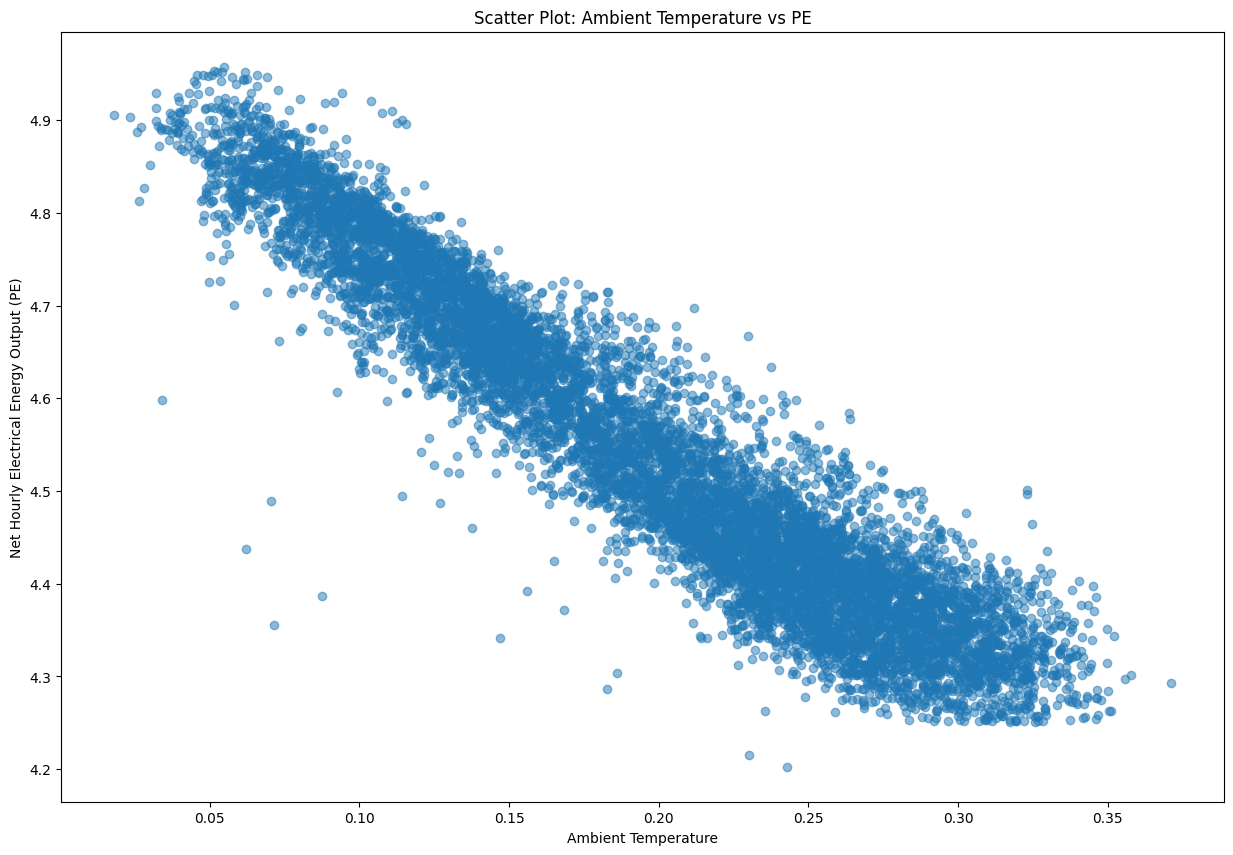

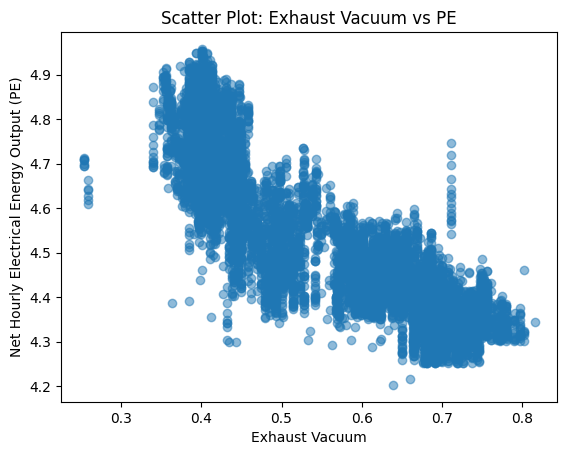

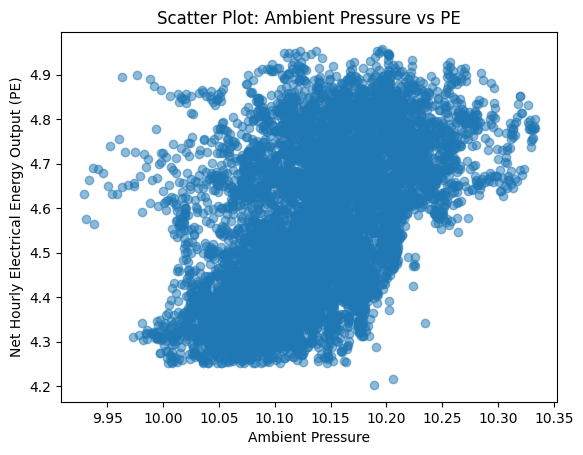

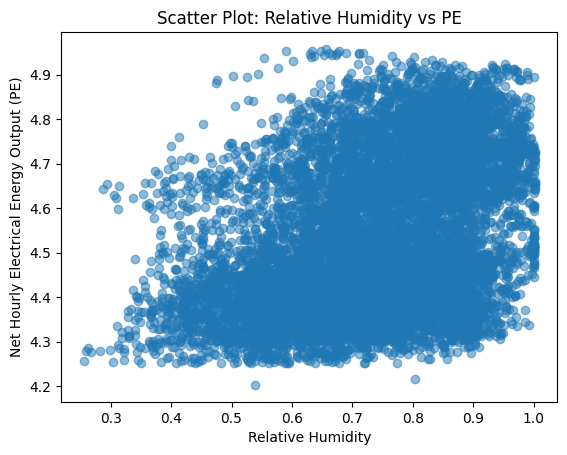

In [15]:
df_scaled=df*0.01
plt.figure(figsize=(15, 10))

# Iterate through each column (excluding the target column 'PE')
for column in df_scaled.columns[:-1]:  # Exclude the last column ('PE')
    # Scatter plot
    plt.scatter(df_scaled[column], df_scaled['Net Hourly Electrical Energy Output'], alpha=0.5)
    
    # Title and labels
    plt.title(f'Scatter Plot: {column} vs PE')
    plt.xlabel(column)
    plt.ylabel('Net Hourly Electrical Energy Output (PE)')
    
    # Show the plot
    plt.show()

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# Assuming your DataFrame is named df
X = df.drop("Net Hourly Electrical Energy Output", axis=1)
y = df["Net Hourly Electrical Energy Output"]

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a list of regression models with their hyperparameters
models = [
    ("RandomForest", RandomForestRegressor(), {"n_estimators": [50, 100, 200], "max_depth": [None, 10, 20]}),
    ("GradientBoosting", GradientBoostingRegressor(), {"n_estimators": [50, 100, 200], "learning_rate": [0.01, 0.1, 0.2]}),
    ("LinearRegression", LinearRegression(), {}),
    ("Lasso", Lasso(), {"alpha": [0.01, 0.1, 1.0]}),
    ("Ridge", Ridge(), {"alpha": [0.01, 0.1, 1.0]}),
    ("SVR", SVR(), {"C": [0.1, 1, 10], "kernel": ["linear", "rbf"]})
]

# Create a pipeline with a scaler and a regressor
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', RandomForestRegressor())  
])

# Evaluate each model
for name, model, param_grid in models:
    print(f"\nTraining {name}...")
    
    # Create a GridSearchCV object for hyperparameter tuning
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    
    # Fit the model with hyperparameter tuning
    grid_search.fit(X_train, y_train)
    
    # Print the best hyperparameters
    print(f"Best Hyperparameters: {grid_search.best_params_}")
    
    # Fit the model with the best hyperparameters on the entire training set
    best_model = grid_search.best_estimator_
    best_model.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = best_model.predict(X_test)
    
    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    rmse = mse ** 0.5
    r2 = r2_score(y_test, y_pred)  # Calculate R-squared
    
    print(f"Mean Squared Error: {mse}")
    print(f"Root Mean Squared Error: {rmse}")
    print(f"R-squared: {r2}")

    # Fit the pipeline with hyperparameter tuning
    pipeline.named_steps['regressor'] = best_model
    pipeline.fit(X_train, y_train)
    
    # Make predictions on the test set using the pipeline
    y_pred_pipeline = pipeline.predict(X_test)
    
    # Evaluate the pipeline
    mse_pipeline = mean_squared_error(y_test, y_pred_pipeline)
    rmse_pipeline = mse_pipeline ** 0.5
    r2_pipeline = r2_score(y_test, y_pred_pipeline)  # Calculate R-squared
    
    print(f"\nPipeline Mean Squared Error: {mse_pipeline}")
    print(f"Pipeline Root Mean Squared Error: {rmse_pipeline}")
    print(f"Pipeline R-squared: {r2_pipeline}")



Training RandomForest...
Best Hyperparameters: {'max_depth': None, 'n_estimators': 200}
Mean Squared Error: 11.777427236354992
Root Mean Squared Error: 3.431825641893101
R-squared: 0.95959902435331

Pipeline Mean Squared Error: 11.895911581489658
Pipeline Root Mean Squared Error: 3.4490450245668955
Pipeline R-squared: 0.9591925787819442

Training GradientBoosting...
Best Hyperparameters: {'learning_rate': 0.2, 'n_estimators': 200}
Mean Squared Error: 12.622064129583531
Root Mean Squared Error: 3.552754442623854
R-squared: 0.9567016042403428

Pipeline Mean Squared Error: 11.81629736701527
Pipeline Root Mean Squared Error: 3.4374841624384644
Pipeline R-squared: 0.9594656852826731

Training LinearRegression...
Best Hyperparameters: {}
Mean Squared Error: 21.669385247620582
Root Mean Squared Error: 4.655038694535265
R-squared: 0.9256659125886638

Pipeline Mean Squared Error: 11.787510411891128
Pipeline Root Mean Squared Error: 3.4332943963329345
Pipeline R-squared: 0.9595644352939933

Tra

In [29]:
def predict_using_models(models, X_data):
    predictions = {}
    
    for name, model, _ in models:
        y_pred = model.predict(X_data)
        
        # Store predictions in the dictionary
        predictions[name] = y_pred
    
    return predictions



In [30]:
data = {
    'Ambient Temperature': [8.34],
    'Exhaust Vacuum': [40.77],
    'Ambient Pressure': [1010.48],
    'Relative Humidity': [40.01],
    'Net Hourly Electrical Energy Output': [480.48]
}

df_pred = pd.DataFrame(data)
		
# Initialize X and y
X_data = df_pred.drop("Net Hourly Electrical Energy Output", axis=1)
y_data = df_pred["Net Hourly Electrical Energy Output"]

In [32]:
df_pred


,Ambient Temperature,Exhaust Vacuum,Ambient Pressure,Relative Humidity,Net Hourly Electrical Energy Output
0,8.34,40.77,1010.48,40.01,480.48


In [31]:
from sklearn.utils.validation import check_is_fitted, NotFittedError

def predict_using_models(models, X_data, X_train, y_train):
    predictions = {}
    
    for name, model, _ in models:
        try:
            check_is_fitted(model)
        except NotFittedError:
            model.fit(X_train, y_train)
        
        y_pred = model.predict(X_data)
        
        # Store predictions in the dictionary
        predictions[name] = y_pred
    
    return predictions


# Use the function to get predictions
predictions = predict_using_models(models, X_data, X_train, y_train)

# Print or use the predictions as needed
for name, y_pred in predictions.items():
    print(f"Prediction using {name}: {y_pred[0]}")


Prediction using RandomForest: 484.1325999999998
Prediction using GradientBoosting: 485.1082120236825
Prediction using LinearRegression: 485.1843388349585
Prediction using Lasso: 484.33930759750797
Prediction using Ridge: 485.18400416197835
Prediction using SVR: 453.3100146274651


In [ ]:
for name, model, param_grid in models:
    model_filename = f"{name.lower()}_model.joblib"
    dump(model, model_filename)
    print(f"Model {name} saved as {model_filename}")
